# 2021-10-18 Iterative methods

## Last time

* Sparse direct solvers
  * matrix orderings
  * impact on formulation
  * cost scaling
* Discussion with Ioana Fleming

## Today

* Why iterative solvers
* Stationary iterative methods
* Preconditioning

In [20]:
using Plots
using LinearAlgebra
using SparseArrays

default(linewidth=4)

function advdiff_matrix(n; kappa=1, wind=[0, 0])
    "Advection-diffusion with Dirichlet boundary conditions eliminated"
    h = 2 / (n + 1)
    rows = Vector{Int64}()
    cols = Vector{Int64}()
    vals = Vector{Float64}()
    idx((i, j),) = (i-1)*n + j
    in_domain((i, j),) = 1 <= i <= n && 1 <= j <= n
    stencil_advect = [-wind[1], -wind[2], 0, wind[1], wind[2]] / h
    stencil_diffuse = [-1, -1, 4, -1, -1] * kappa / h^2
    stencil = stencil_advect + stencil_diffuse
    for i in 1:n
        for j in 1:n
            neighbors = [(i-1, j), (i, j-1), (i, j), (i+1, j), (i, j+1)]
            mask = in_domain.(neighbors)
            append!(rows, idx.(repeat([(i,j)], 5))[mask])
            append!(cols, idx.(neighbors)[mask])
            append!(vals, stencil[mask])
        end
    end
    sparse(rows, cols, vals)
end

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

my_spy (generic function with 1 method)

# Why iterative solvers over direct solvers?

* Less reliable, more leaky abstraction
* More sensitive to problem formulation
* Slower for small problems
* Several different strategies, each with tuning knobs
* Accuracy tolerances needed

## $O(N)$ solvers available for many important problems
* High-order discretization *can* be okay

# Gradient descent

Suppose $A$ is a symmetric positive definite matrix and consider the scalar functional

$$f(u) = \frac 1 2 u^T A u - b^T u . $$

Then the gradient is

$$\nabla_u f = A u - b .$$

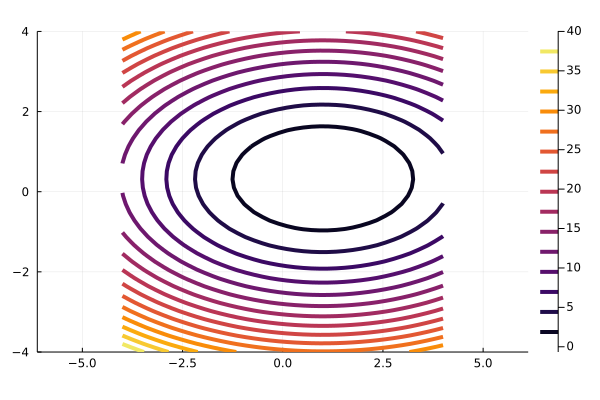

In [11]:
x = LinRange(-4, 4, 40)
A = [1 0; 0 3]
b = [1, 1] 
f(u) = .5 * u' * A * u - b' * u
contour(x, x, (u1, u2) -> f([u1, u2]), aspect_ratio=:equal)

# Aside: Derivative of a dot product

Let $f(\boldsymbol x) = \boldsymbol y^T \boldsymbol x = \sum_i y_i x_i$ and compute the derivative

$$ \frac{\partial f}{\partial \boldsymbol x} = \begin{bmatrix} y_0 & y_1 & \dotsb \end{bmatrix} = \boldsymbol y^T . $$

Note that $\boldsymbol y^T \boldsymbol x = \boldsymbol x^T \boldsymbol y$ and we have the product rule,

$$ \frac{\partial \lVert \boldsymbol x \rVert^2}{\partial \boldsymbol x} = \frac{\partial \boldsymbol x^T \boldsymbol x}{\partial \boldsymbol x} = 2 \boldsymbol x^T . $$

Also,
$$ \frac{\partial \lVert \boldsymbol x - \boldsymbol y \rVert^2}{\partial \boldsymbol x} = \frac{\partial (\boldsymbol x - \boldsymbol y)^T (\boldsymbol x - \boldsymbol y)}{\partial \boldsymbol x} = 2 (\boldsymbol x - \boldsymbol y)^T .$$

# Aside: Variational notation

It's convenient to express derivatives in terms of how they act on an infinitessimal perturbation. So we might write

$$ \delta f = \frac{\partial f}{\partial x} \delta x .$$

(It's common to use $\delta x$ or $dx$ for these infinitesimals.) This makes inner products look like a normal product rule

$$ \delta(\mathbf x^T \mathbf y) = (\delta \mathbf x)^T \mathbf y + \mathbf x^T (\delta \mathbf y). $$

A powerful example of variational notation is differentiating a matrix inverse

$$ 0 = \delta I = \delta(A^{-1} A) = (\delta A^{-1}) A + A^{-1} (\delta A) $$
and thus
$$ \delta A^{-1} = - A^{-1} (\delta A) A^{-1} $$

# Try gradient descent

$$ u_{k+1} = u_k - \omega \nabla_u f $$

In [35]:
function grad_descent(loss, grad, u0; omega=1e-3, tol=1e-5)
    """Minimize loss(c) via gradient descent with initial guess u0
    using learning rate gamma.  Declares convergence when gradient
    is less than tol or after 500 steps.
    """
    u = copy(u0)
    uhist = [copy(u)]
    lhist = [loss(u)]
    for it in 1:500
        g = grad(u)
        u -= omega * g
        push!(uhist, copy(u))
        push!(lhist, loss(u))
        if norm(g) < tol
            break
        end
    end
    (u, hcat(uhist...), lhist)
end

grad_descent (generic function with 1 method)

# Visualize gradient descent

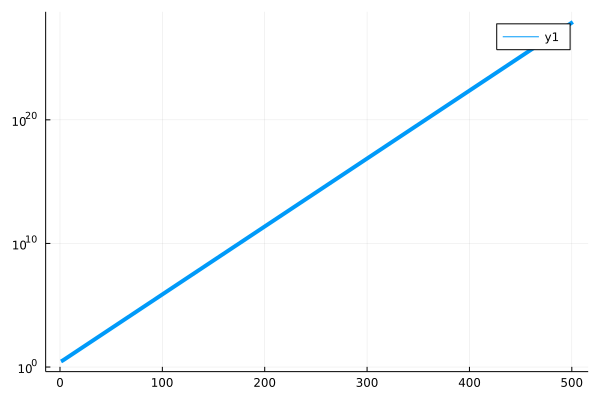

In [47]:
A = [1 1; 1 4]
loss(u) = .5 * u' * A * u
grad(u) = A * u
u, uhist, lhist = grad_descent(loss, grad, [.9, .9],
    omega=.48)
plot(lhist, yscale=:log10)

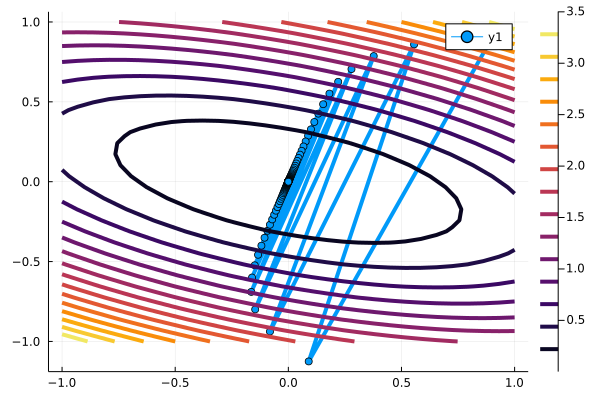

In [46]:
plot(uhist[1, :], uhist[2, :], marker=:circle)
x = LinRange(-1, 1, 30)
contour!(x, x, (x,y) -> loss([x, y]))

# Richardson iteration

The simplest iterative method is [Richardson's method](https://en.wikipedia.org/wiki/Modified_Richardson_iteration), which solves $A u = b$ by the iteration
$$ u_{k+1} = u_k + \omega (b - A u_k) $$
where $\omega > 0$ is a damping parameter and $u_0$ is an initial guess (possibly the zero vector).

* Algebraically equivalent to gradient descent when $A$ is SPD
* Non-symmetric matrices are harder to visualize

# Richardson convergence

$$ u_{k+1} = u_k + \omega (b - A u_k) $$

If $b = A u_*$, this iteration is equivalent to
\begin{align}
u_{k+1} - u_* &= (u_k - u_*) - \omega A (u_k - u_*) \\
&= (I - \omega A) (u_k - u_*) .
\end{align}
It is convenient for convergence analysis to identify the "error" $e_k = u_k - u_*$, in which this becomes
$$ e_{k+1} = (I - \omega A) e_k $$
or
$$ e_k = (I - \omega A)^k e_0 $$
in terms of the initial error.  Evidently powers of the *iteration matrix* $I - \omega A$ tell the whole story.

Suppose that the eigendecomposition
$$ X \Lambda X^{-1} = I - \omega A $$
exists.  Then
$$ (I - \omega A)^k = (X \Lambda X^{-1})^k = X \Lambda^k X^{-1} $$
and the convergence (or divergence) rate depends only on the largest magnitude eigenvalue.
This analysis isn't great for two reasons:

1. Not all matrices are diagonalizable.
2. The matrix $X$ may be very ill-conditioned.

# Aside: Schur decomposition

We can repair these weaknesses by using the [Schur decomposition](https://en.wikipedia.org/wiki/Schur_decomposition)
$$ Q R Q^h = I - \omega A $$
where $R$ is right-triangular and $Q$ is unitary (i.e., orthogonal if real-valued; $Q^h$ is the Hermitian conjugate of $Q$).
The Schur decomposition always exists and $Q$ has a condition number of 1.

* Where are the eigenvalues in $R$?

Evidently we must find $\omega$ to minimize the maximum eigenvalue of $I - \omega A$.  We can do this if $A$ is well conditioned, but not in general.

# Ill-conditioning

## Question: What is the condition number of the Laplacian on 100 evenly spaced points?

* How does it scale under grid refinement?

In [24]:
A = advdiff_matrix(10)
cond(Matrix(A))

48.37415007870825

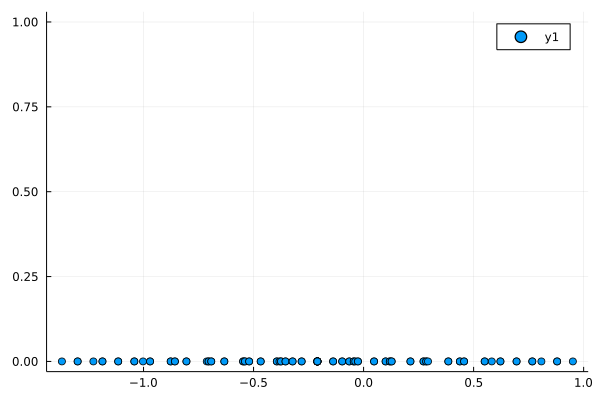

In [28]:
omega = .01
ev = eigvals(Matrix(I - omega * A))
scatter(real.(ev), imag.(ev))

# Monic polynomials small on the spectrum

Equivalently to finding $\omega$ such that $\lVert I - \omega A \rVert$ is minimized, we may seek a monic polynomial $p(z) = 1 - \omega z$ that minimizes

$$ \max_{\lambda \in \sigma(A)} \lvert p(\lambda) \rvert . $$

This concept can be extended to higher degree polynomials, which is essentially what Krylov methods do (discovering the polynomial adaptively, weighted by the right hand side).

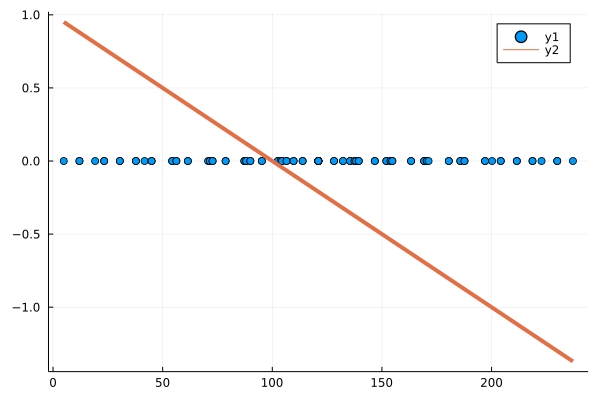

In [34]:
ev = eigvals(Matrix(A))
scatter(real.(ev), zero.(ev))
plot!(x -> 1 - omega * x)

# Preconditioning

Preconditioning is the act of creating an "affordable" operation "$P^{-1}$" such that $P^{-1} A$ (or $A P^{-1}$) is is well-conditoned or otherwise has a "nice" spectrum.  We then solve the system

$$ P^{-1} A x = P^{-1} b \quad \text{or}\quad A P^{-1} \underbrace{(P x)}_y = b $$

in which case the convergence rate depends on the spectrum of the iteration matrix
$$ I - \omega P^{-1} A . $$

* The preconditioner must be applied on each iteration.
* It is *not* merely about finding a good initial guess.

There are two complementary techniques necessary for efficient iterative methods:

* "accelerators" or Krylov methods, which use orthogonality to adaptively converge faster than Richardson
* preconditioners that improve the spectrum of the preconditioned operator

Although there is ongoing research in Krylov methods and they are immensely useful, I would say preconditioning is 90% of the game for practical applications, particularly as a research area.